In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict, Counter
from functools import reduce
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
collection_name = 'week22_lipschitz_son'
collection = seml.database.get_collection(collection_name)

In [5]:
by_status = defaultdict(set)
for r in collection.find():
    by_status[r['status']].add(r['config']['data']['dataset'])

In [6]:
by_status

defaultdict(set,
            {'COMPLETED': {'cora_full'},
             'FAILED': {'cora_full'},
             'RUNNING': {'cora_full'},
             'PENDING': {'amazon_photo', 'citeseer', 'cora_full'}})

In [7]:
collection_name = 'week22_lipschitz_son'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [8]:
experiments_killed = [r for r in collection.find() if r['status'] in ('KILLED',)]

In [9]:
[ex['fail_trace'] for ex in experiments_killed]

[]

In [10]:
set(e['config']['data']['dataset'] for e in experiments_killed)

set()

In [11]:
keys = set()
for ex in experiments:
    keys |= set(ex['metrics'].keys())

list(keys)

['misclassification_auroc_gpc-eye-mode:max-relative:False:no_loc_fit-95conf_val',
 'ood_auroc_feature-distance_loc_fit-mask_val',
 'ood_aucpr_gpc-diag-mode:weighted-relative:True:no_loc_fit-95conf_test',
 'ood_aucpr_gpc-iso-mode:max-relative:True:no_loc_fit-mask_val',
 'misclassification_aucpr_gpc-iso-mode:max-relative:False:no_loc_fit-95conf-no-edges_val',
 'ood_auroc_max-score_loc-no-edges_val',
 'misclassification_aucpr_gpc-iso-mode:max-relative:True:no_loc_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:weighted-relative:False:no_loc_fit-mask-no-edges_test',
 'ood_auroc_gpc-diag-mode:max-relative:False:no_loc_fit-95conf-no-edges_val',
 'misclassification_aucpr_gpc-diag-mode:max-relative:False:no_loc_fit-mask_val',
 'ood_auroc_gpc-full-mode:max-relative:False:no_loc_fit-95conf_val',
 'ood_aucpr_gpc-diag-mode:weighted-relative:False:no_loc_fit-mask-no-edges_test',
 'misclassification_auroc_total-predictive-entropy_loc_test',
 'ood_aucpr_gpc-iso-mode:weighted-relative:

In [12]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
PROXY = 'Proxy'
EXPERIMENT = 'Experiment'
DATASET = 'Dataset'


RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Norm'
SPECTRAL_OUTPUT_NORM = 'Spectral Norm on Last Layer'
WEIGHT_SCALE = 'Weight Scale'
LOWER_LIPSCHITZ = 'Empirical Lower Lipschitz Bound'
UPPER_LIPSCHITZ = 'Empirical Upper Lipschitz Bound'



EPISTEMIC = 'Epistemic'
ALEATORIC = 'Aleatoric'

ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'

In [13]:
mode = 'test'

In [14]:
ex['config']['model']

{'activation': 'leaky_relu',
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'residual': True,
 'use_bias': True,
 'use_spectral_norm': True,
 'use_spectral_norm_on_last_layer': False,
 'weight_scale': 1.5}

In [15]:
[k for k in ex['metrics'].keys() if 'no-edges' in k and 'auroc' in k]

['ood_auroc_total-predictive-entropy_loc-no-edges_val',
 'misclassification_auroc_total-predictive-entropy_loc-no-edges_val',
 'ood_auroc_max-score_loc-no-edges_val',
 'misclassification_auroc_max-score_loc-no-edges_val',
 'ood_auroc_logit-energy_loc-no-edges_val',
 'misclassification_auroc_logit-energy_loc-no-edges_val',
 'ood_auroc_gpc-full-mode:weighted-relative:False:no_loc_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:weighted-relative:False:no_loc_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:weighted-relative:True:no_loc_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:weighted-relative:True:no_loc_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:max-relative:False:no_loc_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:max-relative:False:no_loc_fit-mask-no-edges_val',
 'ood_auroc_gpc-full-mode:max-relative:True:no_loc_fit-mask-no-edges_val',
 'misclassification_auroc_gpc-full-mode:max-relative:True:no_loc_fit-mask-no-edges_va

In [16]:
# epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-95conf'
aleatoric_proxy = 'ood_max-score'
epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-mask'
# metric = 'auroc'
# METRIC = 'AUC-ROC'
metric = 'auroc'
METRIC = 'AUC-ROC'

In [17]:
Counter(ex['config']['model']['use_spectral_norm_on_last_layer'] for ex in experiments)

Counter({False: 187, True: 141})

In [18]:
data_proxy, data_acc_ece = [], []

unrecognized = set()

for ex in experiments:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        RESIDUAL : cfg['model']['residual'],
        SPECTRAL_NORM :  cfg['model']['use_spectral_norm'],
        WEIGHT_SCALE : cfg['model']['weight_scale'],
        SPECTRAL_OUTPUT_NORM : {True : 'Output Norm.', False : 'No Ouput Norm.'}[cfg['model']['use_spectral_norm_on_last_layer']],
        DATASET :  cfg['data']['dataset'],
        LOWER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_min_perturbation_noise_{mode}'][0]['value'],
        UPPER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_max_perturbation_noise_{mode}'][0]['value'],
    }
    data_acc_ece.append(base | {
        ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
        ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
    })
    for k, vs in ex['metrics'].items():
        if metric in k and k.endswith('_' + mode):
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == aleatoric_proxy:
                metric_cfg[PROXY] = ALEATORIC
            elif k == epistemic_proxy:
                metric_cfg[PROXY] = EPISTEMIC
            else:
                unrecognized.add(k)
                continue
            
            for v in vs:
                v = v['value']
                data_proxy.append({
                    METRIC : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base | {
                    ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
                    ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
                }
                )
                

In [19]:
list(unrecognized)

['ood_gpc-eye-mode:max-relative:True:no_fit-95conf',
 'ood_gpc-diag-mode:weighted-relative:True:no_fit-mask',
 'ood_gpc-eye-mode:max-relative:False:no_fit-95conf',
 'ood_gpc-eye-mode:weighted-relative:True:no_fit-mask',
 'ood_gpc-full-mode:weighted-relative:False:no_fit-mask',
 'misclassification_gpc-diag-mode:max-relative:True:no_fit-mask',
 'misclassification_total-predictive-entropy',
 'misclassification_gpc-iso-mode:weighted-relative:False:no_fit-mask',
 'ood_gpc-full-mode:weighted-relative:True:no_fit-mask',
 'ood_gpc-iso-mode:max-relative:True:no_fit-95conf',
 'ood_gpc-diag-mode:weighted-relative:False:no_fit-95conf',
 'ood_gpc-full-mode:max-relative:True:no_fit-mask',
 'misclassification_gpc-diag-mode:weighted-relative:False:no_fit-mask',
 'misclassification_gpc-full-mode:weighted-relative:True:no_fit-95conf',
 'misclassification_feature-distance_fit-95conf',
 'ood_gpc-eye-mode:max-relative:True:no_fit-mask',
 'misclassification_gpc-full-mode:weighted-relative:False:no_fit-mask'

In [20]:
df_proxy = pd.DataFrame(data_proxy)
df_acc_ece = pd.DataFrame(data_acc_ece)

In [21]:
df_proxy[
    (df_proxy[EXPERIMENT] == LOC) &
    (df_proxy[NO_EDGES] == False) &
    (df_proxy[SETTING] == HYBRID) &
    (df_proxy[PROXY] == EPISTEMIC) &
    (df_proxy[SPECTRAL_NORM] == True)
]

,AUC-ROC,No Edges,Experiment,Proxy,Setting,Residual,Spectral Norm,Weight Scale,Spectral Norm on Last Layer,Dataset,Empirical Lower Lipschitz Bound,Empirical Upper Lipschitz Bound,Accuracy,Expected Calibration Error
207,0.673529,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,No Ouput Norm.,cora_full,0.000598,0.058972,0.315789,0.165085
211,0.702435,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,No Ouput Norm.,cora_full,0.000771,0.061731,0.259414,0.108720
215,0.662410,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,No Ouput Norm.,cora_full,0.000552,0.061141,0.265010,0.109195
219,0.470948,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,No Ouput Norm.,cora_full,0.000725,0.071773,0.658947,0.501022
223,0.457748,False,Leave Out Classes,Epistemic,Inductive,False,True,0.5,No Ouput Norm.,cora_full,0.000575,0.082739,0.550209,0.391844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,0.794217,False,Leave Out Classes,Epistemic,Inductive,True,True,1.1,Output Norm.,cora_full,0.189591,1.972529,0.771967,0.599671
1235,0.719729,False,Leave Out Classes,Epistemic,Inductive,True,True,1.1,Output Norm.,cora_full,0.152616,1.488086,0.732919,0.563043
1239,0.578653,False,Leave Out Classes,Epistemic,Inductive,True,True,1.1,Output Norm.,cora_full,0.179344,2.037096,0.724211,0.551401
1243,0.771416,False,Leave Out Classes,Epistemic,Inductive,True,True,1.1,Output Norm.,cora_full,0.090875,1.233518,0.688285,0.515256


In [22]:
set(df_proxy[WEIGHT_SCALE])

{0.5, 0.9, 1.0, 1.1, 1.5}

In [23]:
def plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(df, x=None, y=None, row=None, col=None, hue=None, style=None, 
                                      ci=95, 
                                      facet_kws = {'margin_titles' : True, 'height' : 1, }, log_x = True, binned=True):
    
    g = sns.FacetGrid(df, row = row, col = col, hue = hue, **facet_kws)
    
    styles = ['solid', 'dotted', 'dashed']
    markers = ['o', 'x', '+']
    label_to_color = {}
    style_to_linestyle = {}
    style_to_marker = {}
    style_name = style
    
    def plot_lines(x, y, style, sn, color=None, label=None, ci=ci):
        label_to_color[label] = color
        
        for style_idx, st in enumerate(sorted(np.unique(style).tolist())):
            style_to_linestyle[st] = styles[style_idx]
            style_to_marker[st] = markers[style_idx]
            # Bin the ones with spectral norm according to lipschitz constant
            
            x_style, y_style = x[(style == st) & (sn == True)], y[(style == st) & (sn == True)]
            if log_x:
                x_style = np.log(x_style)
            
            if binned:
                if x_style.shape[0] == 0:
                    continue
                else:
                    print(x_style.shape)
                mean, bin_edges, bin_idx = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], statistic='mean', bins=10)
                std, _, _ = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], bins=bin_edges, statistic='std')
                bin_centers = (0.5 * (bin_edges[:-1] + bin_edges[1:]))
                if log_x:
                    bin_centers = np.exp(bin_centers)
                
            else:
                bin_centers = np.sort(np.unique(x_style))
                mean = np.array([(y_style[x_style == center]).mean() for center in bin_centers])
                std = np.array([(y_style[x_style == center]).std() for center in bin_centers])
               
            plot_mask = np.isfinite(mean) & np.isfinite(std)

            plt.plot(bin_centers[plot_mask], mean[plot_mask], color=color, label=f'{label}, {st}', linestyle=styles[style_idx])
            plt.fill_between(bin_centers[plot_mask],( mean - std)[plot_mask], (mean + std)[plot_mask], alpha = 0.2, color=color)
             
            # Put the ones without spectral norm into one bin put as a point
            x_style, y_style = x[(style == st) & (sn == False)], y[(style == st) & (sn == False)]
            x_std, y_std = x_style.std(), y_style.std()
            _x, _y = np.array([x_style.mean()]), np.array([y_style.mean()])
            if (np.isfinite(_x) & np.isfinite(_y)).all():
                plt.errorbar(_x, _y, yerr=y_style.std(), xerr = x_style.std(), ecolor='gray', capsize=2, fmt=markers[style_idx], color=color)
        
    g.map(plot_lines, x, y, style, SPECTRAL_NORM, ci=ci)
    
    # Create a legend (extremely hacky)
    
    lines, line_labels = [], []
    for label, color in label_to_color.items():
        lines.append(Line2D([0], [0], color=color))
        line_labels.append(label)
    l1 = plt.legend(lines, line_labels, title=hue, loc='center left', bbox_to_anchor=(1.2, 1.7), frameon=False)
    
    lines, line_labels = [], []
    for style, ls in style_to_linestyle.items():
        lines.append(Line2D([0], [0], color='black', ls=ls))
        line_labels.append(style)
    l2 = plt.legend(lines, line_labels, title=f'{style_name}', loc='center left', bbox_to_anchor=(1.2, 1.2), frameon=False)
    
    
    lines, line_labels = [], []
    for style, marker in style_to_marker.items():
        lines.append(plt.errorbar([], [], xerr=[], yerr=[], color='black', ecolor='gray', capsize=10, fmt=marker))
        line_labels.append(style)
    l3 = plt.legend(lines, line_labels, title=f'{style_name},\nNo Spectral Norm.', loc='center left', frameon=False, 
                                                bbox_to_anchor=(1.2, 0.6))
    
    g.axes.flatten()[-1].add_artist(l1)
    g.axes.flatten()[-1].add_artist(l2)
    
    
    if log_x:
        g.set(xscale='log')
    return g


In [24]:
dataset = dc.CORA_FULL

In [25]:
x_quantity = WEIGHT_SCALE
x_quantity_fn = x_quantity.replace(' ','-')
if x_quantity == WEIGHT_SCALE:
    x_log = True
else:
    x_log = True

In [26]:
%pwd

'/nfs/homedirs/fuchsgru/MastersThesis'

(30,)
(30,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


(45,)
(45,)
(40,)
(40,)
(36,)
(36,)
(33,)
(33,)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


(30,)
(30,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


(45,)
(45,)
(40,)
(40,)
(36,)
(36,)
(33,)
(33,)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


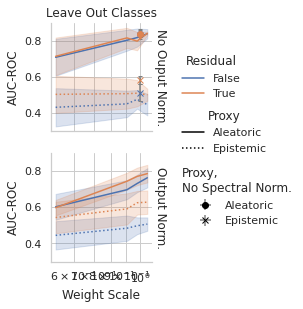

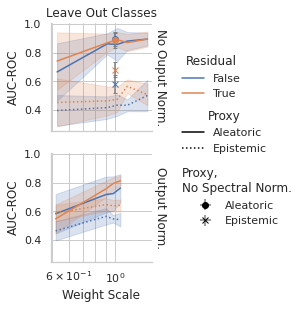

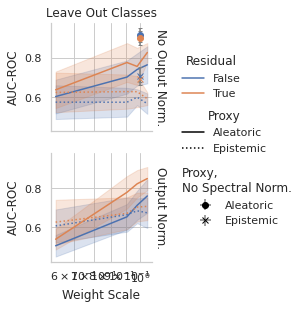

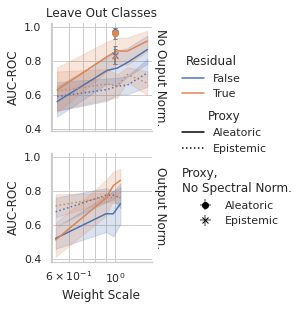

In [27]:
for no_edges, fn_suffix in ((True, '-no-edges'), (False, '')):
    for setting in (HYBRID, TRANSDUCTIVE):

        sns.set(context='notebook', font_scale=1.0)
        sns.set_style("whitegrid")

        g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
            df_proxy[
                (df_proxy[NO_EDGES] == no_edges) & 
                (df_proxy[DATASET] == dataset) &
                (df_proxy[SETTING] == setting)
            ],
            x = x_quantity, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY,
            facet_kws = {'margin_titles' : True, 'height' : 2.0, 'aspect' : 1.2, }, log_x=x_log)
        for ax in g.axes.flatten():
            ax.xaxis.grid(True, which='minor')
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
        g.fig.subplots_adjust(wspace=0.1, hspace=0.2)
        g.set_axis_labels(x_var=x_quantity, clear_inner=True)

        g.figure.savefig(f'thesis_nbs/spectral_norm_plots/{dataset}-{setting.lower()}-{metric}-{x_quantity_fn}{fn_suffix}.pdf', bbox_inches='tight')

(30,)
(30,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


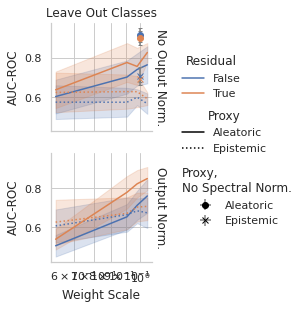

In [28]:
sns.set(context='notebook', font_scale=1.0)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == False) & 
        (df_proxy[DATASET] == dataset) &
        (df_proxy[SETTING] == HYBRID)
    ],
    x = x_quantity, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY,
    facet_kws = {'margin_titles' : True, 'height' : 2.0, 'aspect' : 1.2, }, log_x=x_log)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.subplots_adjust(wspace=0.1, hspace=0.2)
g.set_axis_labels(x_var=x_quantity, clear_inner=True)

g.figure.savefig(f'thesis_nbs/spectral_norm_plots/{dataset}-hybrid-{metric}-{x_quantity_fn}.pdf', bbox_inches='tight')

(30,)
(30,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


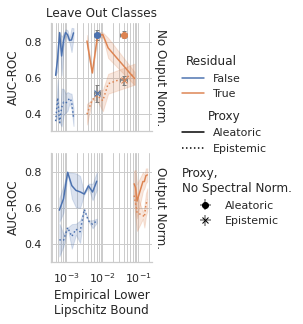

In [29]:
sns.set(context='notebook', font_scale=1.0)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == True) & 
        (df_proxy[DATASET] == dataset) &
        (df_proxy[SETTING] == HYBRID)
    ],
    x = LOWER_LIPSCHITZ, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY,
    facet_kws = {'margin_titles' : True, 'height' : 2.0, 'aspect' : 1.2, })
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.subplots_adjust(wspace=0.1, hspace=0.2)
g.set_axis_labels(x_var='Empirical Lower\nLipschitz Bound', clear_inner=True)

g.figure.savefig(f'thesis_nbs/spectral_norm_plots/{dataset}-hybrid-{metric}-no-edges.pdf', bbox_inches='tight')

(45,)
(45,)
(40,)
(40,)
(36,)
(36,)
(33,)
(33,)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


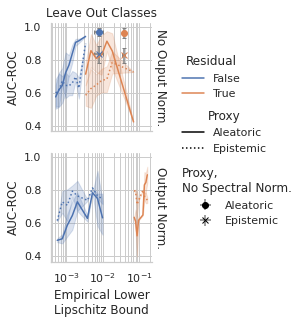

In [30]:
sns.set(context='notebook', font_scale=1.0)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == False) & 
        (df_proxy[DATASET] == dataset) &
        (df_proxy[SETTING] == TRANSDUCTIVE)
    ],
    x = LOWER_LIPSCHITZ, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY,
    facet_kws = {'margin_titles' : True, 'height' : 2.0, 'aspect' : 1.2, })
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.subplots_adjust(wspace=0.1, hspace=0.2)
g.set_axis_labels(x_var='Empirical Lower\nLipschitz Bound', clear_inner=True)

g.figure.savefig(f'thesis_nbs/spectral_norm_plots/{dataset}-transductive-{metric}.pdf', bbox_inches='tight')

(45,)
(45,)
(40,)
(40,)
(36,)
(36,)
(33,)
(33,)


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


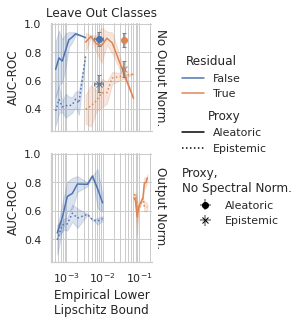

In [31]:
sns.set(context='notebook', font_scale=1.0)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == True) & 
        (df_proxy[DATASET] == dataset) &
        (df_proxy[SETTING] == TRANSDUCTIVE)
    ],
    x = LOWER_LIPSCHITZ, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY,
    facet_kws = {'margin_titles' : True, 'height' : 2.0, 'aspect' : 1.2, })
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.fig.subplots_adjust(wspace=0.1, hspace=0.2)
g.set_axis_labels(x_var='Empirical Lower\nLipschitz Bound', clear_inner=True)

g.figure.savefig(f'thesis_nbs/spectral_norm_plots/{dataset}-transductive-{metric}-no-edges.pdf', bbox_inches='tight')

def plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(df, x=None, y=None, row=None, col=None, hue=None, style=None, 
                                      ci=95, 
                                      facet_kws = {'margin_titles' : True, 'height' : 2, }, log_x = True, binned=True):
    
    g = sns.FacetGrid(df, row = row, col = col, hue = hue, **facet_kws)
    
    styles = ['solid', 'dotted', 'dashed']
    markers = ['o', 'x', '+']
    label_to_color = {}
    style_to_linestyle = {}
    style_to_marker = {}
    style_name = style
    
    def plot_lines(x, y, style, sn, color=None, label=None, ci=ci):
        label_to_color[label] = color
        
        for style_idx, st in enumerate(sorted(np.unique(style).tolist())):
            style_to_linestyle[st] = styles[style_idx]
            style_to_marker[st] = markers[style_idx]
            # Bin the ones with spectral norm according to lipschitz constant
            
            x_style, y_style = x[(style == st) & (sn == True)], y[(style == st) & (sn == True)]
            if log_x:
                x_style = np.log(x_style)
            
            if binned:
                if x_style.shape[0] == 0:
                    continue
                else:
                    print(x_style.shape)
                mean, bin_edges, bin_idx = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], statistic='mean', bins=10)
                std, _, _ = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], bins=bin_edges, statistic='std')
                bin_centers = (0.5 * (bin_edges[:-1] + bin_edges[1:]))
                if log_x:
                    bin_centers = np.exp(bin_centers)
                
            else:
                bin_centers = np.sort(np.unique(x_style))
                mean = np.array([(y_style[x_style == center]).mean() for center in bin_centers])
                std = np.array([(y_style[x_style == center]).std() for center in bin_centers])
               
            plot_mask = np.isfinite(mean) & np.isfinite(std)

            plt.plot(bin_centers[plot_mask], mean[plot_mask], color=color, label=f'{label}, {st}', linestyle=styles[style_idx])
            plt.fill_between(bin_centers[plot_mask],( mean - std)[plot_mask], (mean + std)[plot_mask], alpha = 0.2, color=color)
             
            # Put the ones without spectral norm into one bin put as a point
            x_style, y_style = x[(style == st) & (sn == False)], y[(style == st) & (sn == False)]
            x_std, y_std = x_style.std(), y_style.std()
            _x, _y = np.array([x_style.mean()]), np.array([y_style.mean()])
            if (np.isfinite(_x) & np.isfinite(_y)).all():
                plt.errorbar(_x, _y, yerr=y_style.std(), xerr = x_style.std(), ecolor='gray', capsize=2, fmt=markers[style_idx], color=color)
            
            plt.xticks(size=15)
            plt.yticks(size=15)
        
    g.map(plot_lines, x, y, style, SPECTRAL_NORM, ci=ci)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=18)
    g.set_ylabels('AUC-ROC', size=15)
    
    # Create a legend (extremely hacky)
    
    lines, line_labels = [], []
    for label, color in label_to_color.items():
        lines.append(Line2D([0], [0], color=color))
        line_labels.append(label)
    l1 = plt.legend(lines, line_labels, title=hue, loc='center left', bbox_to_anchor=(1.1, 1.25), frameon=False, fontsize=18, title_fontsize=18)
    
    lines, line_labels = [], []
    for style, ls in style_to_linestyle.items():
        lines.append(Line2D([0], [0], color='black', ls=ls))
        line_labels.append(style)
    l2 = plt.legend(lines, line_labels, title=f'{style_name}', loc='center left', bbox_to_anchor=(1.1, 0.99), frameon=False, fontsize=18, title_fontsize=18)
    
    
    lines, line_labels = [], []
    for style, marker in style_to_marker.items():
        lines.append(plt.errorbar([], [], xerr=[], yerr=[], color='black', ecolor='gray', capsize=10, fmt=marker))
        line_labels.append(style)
    l3 = plt.legend(lines, line_labels, title=f'{style_name},\nNo Spectral Norm', loc='center left', frameon=False, bbox_to_anchor=(1.1, 0.7), fontsize=18, title_fontsize=18)
    
    g.axes.flatten()[-1].add_artist(l1)
    g.axes.flatten()[-1].add_artist(l2)
    
    
    if log_x:
        g.set(xscale='log')
    return g



sns.set(context='notebook', font_scale=1.0)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == False) & 
        (df_proxy[DATASET] == dc.CORA_FULL) &
        (df_proxy[SETTING] == HYBRID)
    ],
    x = LOWER_LIPSCHITZ, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=15)
g.set_xlabels(LOWER_LIPSCHITZ, size=18)